In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import dlc_practical_prologue as prologue

mini_batch_size = 100
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

#normalize the input
train_input/=255
test_input/=255

In [2]:
print_shapes_Net = False

In [3]:
class Siamese_net_auxiliary(nn.Module):
    def __init__(self):
        super(Siamese_net_auxiliary, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 10)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, data):
        if print_shapes_Net:
            print("initial", data.shape) #100 2 14 14
            
        class_layer = []
        final_layer = []
        for i in range(2):
            x = data[:,i,:,:]
            len0 = x.shape[0]
            x = torch.reshape(x, (len0, 1, 14, 14))
            
            if print_shapes_Net:
                print("X START",x.shape) 
            
            x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
            if print_shapes_Net:
                print("conv1",x.shape) 
                
            x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
            if print_shapes_Net:
                print("conv2",x.shape)
            
            x = F.relu(self.fc1(x.view(-1, 256)))
            if print_shapes_Net:
                print("fc1",x.shape) 
                
            final_layer.append(x)
            class_layer.append(x.reshape(x.shape[0], 1, 10))
            
        final_layer = torch.cat((final_layer[1], final_layer[0]), 1)
        class_layer = torch.cat((class_layer[1], class_layer[0]), 1)
        
        if print_shapes_Net:
                print("class layer",class_layer.shape)
                
        final_layer = self.fc2(final_layer)
        if print_shapes_Net:
            print("final",final_layer.shape) 
            
        return class_layer, final_layer

In [4]:
def train_model(model, train_input, train_classes, train_target, mini_batch_size, lr, nb_epoch):
    criterion = nn.MSELoss() #CHANGE LOSS TO CROSS ENTROPY?
    optimizer = optim.Adam(model.parameters(), lr)
    
    for e in range(nb_epoch):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
          
            output_class, output_target = model(train_input.narrow(0, b, mini_batch_size))
            
            loss_class = criterion(output_class, train_classes.narrow(0, b, mini_batch_size))
            loss_target = criterion(output_target, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss = loss_class + loss_target
            loss.backward()
            optimizer.step()
            
            sum_loss = sum_loss + loss.item()
        #print(e, sum_loss)

In [5]:
def compute_nb_errors_targets(model, input, target):
    nb_errors = 0
    _, output = model(input)
    _, predicted_target = output.max(1) #max probabilities of target

    for b in range(1000):
        if target[b,int(predicted_target[b])] <= 0:
            nb_errors = nb_errors + 1
            
    return nb_errors

In [6]:
def compute_nb_errors_classes(model, input, target):
    nb_errors = 0

    output,_ = model(input)
    _, predicted_classes = output.max(2)

    for b in range(input.shape[0]):
        if target[b][0][predicted_classes[b][0]] <= 0:
            nb_errors = nb_errors + 1
        if target[b][1][predicted_classes[b][1]] <= 0:
            nb_errors = nb_errors + 1

    return nb_errors

In [7]:
#train_target[1000,1]
new_train_target = torch.empty(1000,2)
new_test_target = torch.empty(1000,2)
for i in range(1000):
    if train_target[i] == 1 :
        new_train_target[i,0] = 0
        new_train_target[i,1] = 1
        
    else:
        new_train_target[i,0] = 1
        new_train_target[i,1] = 0
        
    if test_target[i] == 1:
        new_test_target[i,0] = 0
        new_test_target[i,1] = 1
        
    else:
        new_test_target[i,0] = 1
        new_test_target[i,1] = 0

In [8]:
#train_classes[1000, 2]
new_train_classes = torch.zeros(1000, 2, 10)
new_test_classes = torch.zeros(1000, 2, 10)

for i in range(train_classes.shape[0]): #
    new_train_classes[i][0][train_classes[i][0]] = 1
    new_train_classes[i][1][train_classes[i][1]] = 1

for i in range(test_classes.shape[0]):
    new_test_classes[i][0][test_classes[i][0]] = 1
    new_test_classes[i][1][test_classes[i][1]] = 1



In [9]:
####predict class of each digit
nb_repetitions = 10
nb_train_errors = []
nb_test_errors = []
lr = 0.001
nb_epoch = 25

for i in range (nb_repetitions):
    model = Siamese_net_auxiliary()
    train_model(model, train_input, new_train_classes, new_train_target, mini_batch_size, lr, nb_epoch)
    
    nb_train_errors.append(compute_nb_errors_targets(model, train_input, new_train_target))
    nb_test_errors.append(compute_nb_errors_targets(model, test_input, new_test_target))

In [13]:
###ANALYSES OF THE RESULTS
import numpy as np
import matplotlib.pyplot as plt

Average train error 6.42% 64.20/1000
Train error standard deviation : 41.94
Average test error 16.96% 169.60/1000
Test error standard deviation : 21.17


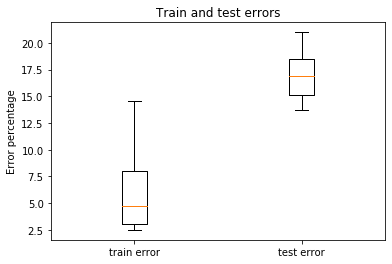

In [15]:
###ANALYSES OF THE RESULTS
print('Average train error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(nb_train_errors)) / train_input.size(0),
                                                      np.mean(nb_train_errors), train_input.size(0)))
print("Train error standard deviation : {:0.2f}".format(np.std(nb_train_errors)))

print('Average test error {:0.2f}% {:0.2f}/{:d}'.format((100 * np.mean(nb_test_errors)) / test_input.size(0),
                                                      np.mean(nb_test_errors), test_input.size(0)))
print("Test error standard deviation : {:0.2f}".format(np.std(nb_test_errors)))


train_err = [x*100 / train_input.size(0) for x in nb_train_errors]
test_err = [x*100 / test_input.size(0) for x in nb_test_errors]

plt.figure
plt.title("Train and test errors")
plt.boxplot([train_err, test_err], labels=['train error', 'test error'])
plt.ylabel("Error percentage")
plt.show()

In [ ]:
#############################################################
#j'ai laissé tes trucs en bas au cas où

In [ ]:
####predict class of each digit
for k in range(1):
    model = Siamese_net_auxiliary()
    lr = 0.005
    nb_epoch = 25
    train_model(model, train_input, new_train_classes, new_train_target, mini_batch_size, lr, nb_epoch)
    
    nb_train_errors = compute_nb_errors_targets(model, train_input, new_train_target)
    print('train error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                      nb_train_errors, train_input.size(0)))
    nb_test_errors = compute_nb_errors_targets(model, test_input, new_test_target)
    print('test error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                    nb_test_errors, test_input.size(0)))

In [ ]:
nb_train_errors = nb_train_errors.append(compute_nb_errors_targets(model, train_input, new_train_target))
print('train error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                  nb_train_errors, train_input.size(0)))
nb_test_errors = nb_test_errors.append(compute_nb_errors_targets(model, test_input, new_test_target))
print('test error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                nb_test_errors, test_input.size(0)))
    

In [ ]:
nb_train_errors_class = compute_nb_errors_classes(model, train_input, new_train_classes)
print('train error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors_class) / (2*train_input.size(0)),
                                                  nb_train_errors_class, 2*train_input.size(0)))
nb_test_errors_class = compute_nb_errors_classes(model, test_input, new_test_classes)
print('test error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors_class) / (2*test_input.size(0)),
                                                nb_test_errors_class, 2*test_input.size(0)))

In [ ]:
#### lr = 0.0005 seems to not overfit
for lr in [0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.5]:
    model = Siamese_net_auxiliary()
    nb_epoch = 25
    train_model(model, train_input, new_train_classes, new_train_target, mini_batch_size, lr, nb_epoch)
    
    print("LR", lr)
    nb_train_errors = compute_nb_errors_targets(model, train_input, new_train_target)
    print('train error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                      nb_train_errors, train_input.size(0)))
    nb_test_errors = compute_nb_errors_targets(model, test_input, new_test_target)
    print('test error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                    nb_test_errors, test_input.size(0)))
    
    nb_train_errors_class = compute_nb_errors_classes(model, train_input, new_train_classes)
    print('train error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors_class) / train_input.size(0),
                                                      nb_train_errors_class, train_input.size(0)))
    nb_test_errors_class = compute_nb_errors_classes(model, test_input, new_test_classes)
    print('test error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors_class) / test_input.size(0),
                                                    nb_test_errors_class, test_input.size(0)))


In [ ]:
####predict class of each digit
for k in range(10):
    model = Siamese_net_auxiliary()
    lr = 0.0005
    nb_epoch = 25
    train_model(model, train_input, new_train_classes, new_train_target, mini_batch_size, lr, nb_epoch)
    
    nb_train_errors = compute_nb_errors_targets(model, train_input, new_train_target)
    print('train error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_input.size(0),
                                                      nb_train_errors, train_input.size(0)))
    nb_test_errors = compute_nb_errors_targets(model, test_input, new_test_target)
    print('test error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                    nb_test_errors, test_input.size(0)))
    
    nb_train_errors_class = compute_nb_errors_classes(model, train_input, new_train_classes)
    print('train error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors_class) / train_input.size(0),
                                                      nb_train_errors_class, train_input.size(0)))
    nb_test_errors_class = compute_nb_errors_classes(model, test_input, new_test_classes)
    print('test error Net_auxiliary_loss {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors_class) / test_input.size(0),
                                                    nb_test_errors_class, test_input.size(0)))
    